 20%|██        | 1/5 [03:56<15:47, 236.81s/it]


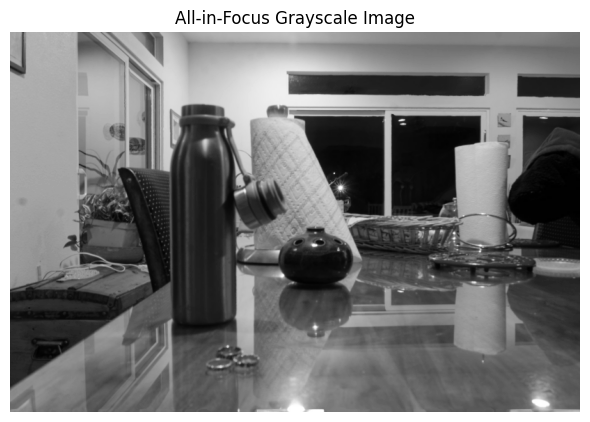

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy import gradient, exp
from skimage.transform import resize
import maxflow
from tqdm import tqdm
import gc

# ----- Load Focal Stack -----
folder_path = '/Users/yannbaglinbunod/Desktop/ece 285 project/photos4'
image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_filenames.sort()

# ----- Alignment (Recursive Flow Composition) -----
def warp_image(img, flow):
    h, w = img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

def compute_optical_flow_pair(img1, img2):
    dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_MEDIUM)
    dis.setUseSpatialPropagation(True)
    return dis.calc(img1, img2, None)

def estimate_affine(img1, img2):
    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return np.eye(2, 3, dtype=np.float32)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = matcher.match(des1, des2)
    if len(matches) < 4:
        return np.eye(2, 3, dtype=np.float32)
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, _ = cv2.estimateAffinePartial2D(dst_pts, src_pts)
    return M if M is not None else np.eye(2, 3, dtype=np.float32)

def compose_flows(f1, f2):
    h, w, _ = f1.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + f1[..., 0]).astype(np.float32)
    map_y = (grid_y + f1[..., 1]).astype(np.float32)
    f2_warped = np.stack([
        cv2.remap(f2[..., 0], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT),
        cv2.remap(f2[..., 1], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    ], axis=-1)
    return f1 + f2_warped

def invert_flow(flow):
    h, w = flow.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = grid_x + flow[..., 0]
    map_y = grid_y + flow[..., 1]
    flow_inv_x = cv2.remap(-flow[..., 0], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    flow_inv_y = cv2.remap(-flow[..., 1], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return np.stack([flow_inv_x, flow_inv_y], axis=-1)

def align_focal_stack_recursive(stack):
    ref_idx = len(stack) // 2
    h, w = stack[0].shape[:2]
    affine_warped = [cv2.warpAffine(stack[i], estimate_affine(stack[ref_idx], stack[i]), (w, h), flags=cv2.INTER_LINEAR) for i in range(len(stack))]
    flows = [compute_optical_flow_pair(affine_warped[i], affine_warped[i + 1]) for i in range(len(stack) - 1)]
    aligned = []
    for i in range(len(stack)):
        if i == ref_idx:
            aligned.append(stack[i])
            continue
        if i < ref_idx:
            flow = flows[i].copy()
            for j in range(i + 1, ref_idx):
                flow = compose_flows(flow, flows[j])
        else:
            flow = invert_flow(flows[i - 1])
            for j in range(i - 2, ref_idx - 1, -1):
                flow = compose_flows(flow, invert_flow(flows[j]))
        warped = warp_image(stack[i], flow)
        aligned.append(warped)
    return np.stack(aligned)

def compute_common_crop_mask(stack):
    h, w = stack[0].shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)
    for img in stack:
        edges = cv2.Canny(img, 100, 200)
        mask = cv2.bitwise_and(mask, (edges == 0).astype(np.uint8))
    return mask

# ----- Preprocessing -----
def compute_patchwise_gradient_stack(stack, sigma=1.0):
    return np.stack([np.sqrt((gx**2 + gy**2)) for gx, gy in [gradient(gaussian_filter(f, sigma)) for f in stack]])

def compute_data_term(stack, sigma=1.0):
    grad_stack = compute_patchwise_gradient_stack(stack, sigma)
    return np.stack([exp(g) for g in grad_stack])

def downsample_stack(stack, shape):
    return np.stack([resize(f, shape, anti_aliasing=True) for f in stack])

def get_edges(H, W):
    return [(y*W+x, y*W+x+1) for y in range(H) for x in range(W-1)] + \
           [(y*W+x, (y+1)*W+x) for y in range(H-1) for x in range(W)]

def alpha_expansion(data_cost, λ=2, max_iters=5):
    N, H, W = data_cost.shape
    flat_cost = data_cost.transpose(1, 2, 0).reshape(-1, N)
    labels = np.argmin(data_cost, axis=0)
    for _ in tqdm(range(max_iters)):
        prev = labels.copy()
        flat_labels = labels.flatten()
        for α in range(N):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(H*W)
            for i in range(H*W):
                g.add_tedge(nodes[i], flat_cost[i, α], flat_cost[i, flat_labels[i]])
            for i, j in get_edges(H, W):
                pi, pj = flat_labels[i], flat_labels[j]
                g.add_edge(nodes[i], nodes[j], λ * abs(α - pj), λ * abs(α - pi))
            g.maxflow()
            for i in range(H*W):
                if g.get_segment(nodes[i]) == 0:
                    flat_labels[i] = α
            labels = flat_labels.reshape(H, W)
            del g
            gc.collect()
        if np.all(labels == prev):
            break
    return labels


# ----- Align grayscale stack -----
focal_stack_gray = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in image_filenames]
focal_stack_gray = [img for img in focal_stack_gray if img is not None]
focal_stack_gray = np.stack(focal_stack_gray)
focal_stack_gray_aligned = align_focal_stack_recursive(focal_stack_gray)

# ----- Compute Common Crop Mask -----
common_mask = compute_common_crop_mask(focal_stack_gray_aligned)
x, y, w, h = cv2.boundingRect(common_mask.astype(np.uint8))
focal_stack_gray_aligned = np.stack([img[y:y+h, x:x+w] for img in focal_stack_gray_aligned])

# ----- Resize grayscale stack and compute focus measures -----
target_shape = (int(focal_stack_gray_aligned.shape[1] * 0.4), int(focal_stack_gray_aligned.shape[2] * 0.4))
focal_stack_small = downsample_stack(focal_stack_gray_aligned, target_shape)
data_cost = compute_data_term(focal_stack_small)
label_map = alpha_expansion(data_cost)

# ----- Reconstruct All-in-Focus Grayscale Image -----
H, W = label_map.shape
gray_stack_resized = np.stack([
    resize(img, label_map.shape, preserve_range=True).astype(np.uint8)
    for img in focal_stack_gray_aligned
])
output_gray = np.zeros((H, W), dtype=np.uint8)
for i in range(H):
    for j in range(W):
        output_gray[i, j] = gray_stack_resized[label_map[i, j], i, j]

# ----- Display Grayscale All-in-Focus Image -----
plt.figure(figsize=(6, 6))
plt.imshow(output_gray, cmap='gray')
plt.title("All-in-Focus Grayscale Image")
plt.axis('off')
plt.tight_layout()
plt.show()

Processing folder: photos1


 20%|██        | 1/5 [12:02<48:08, 722.23s/it]


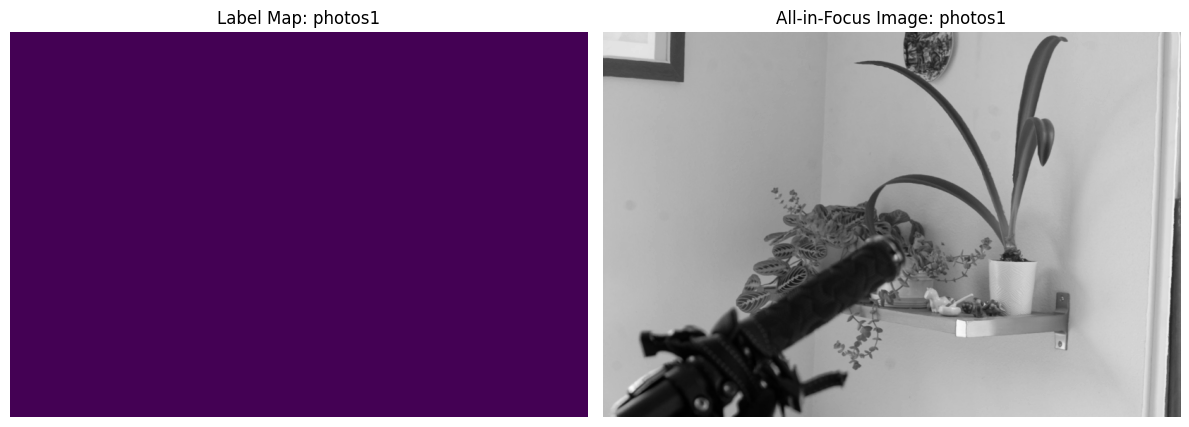

Processing folder: photos2


 20%|██        | 1/5 [46:50<3:07:21, 2810.36s/it]


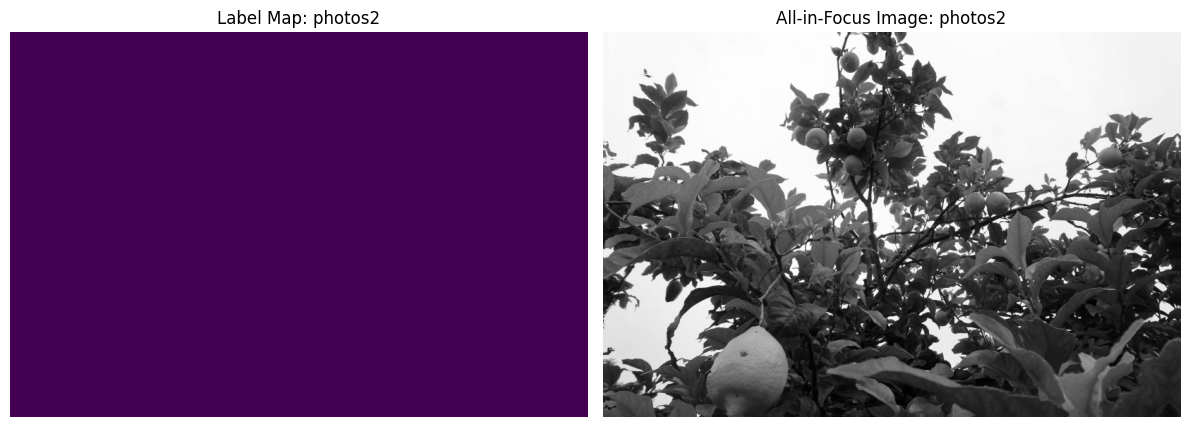

Processing folder: photos3


 20%|██        | 1/5 [01:49<07:16, 109.07s/it]


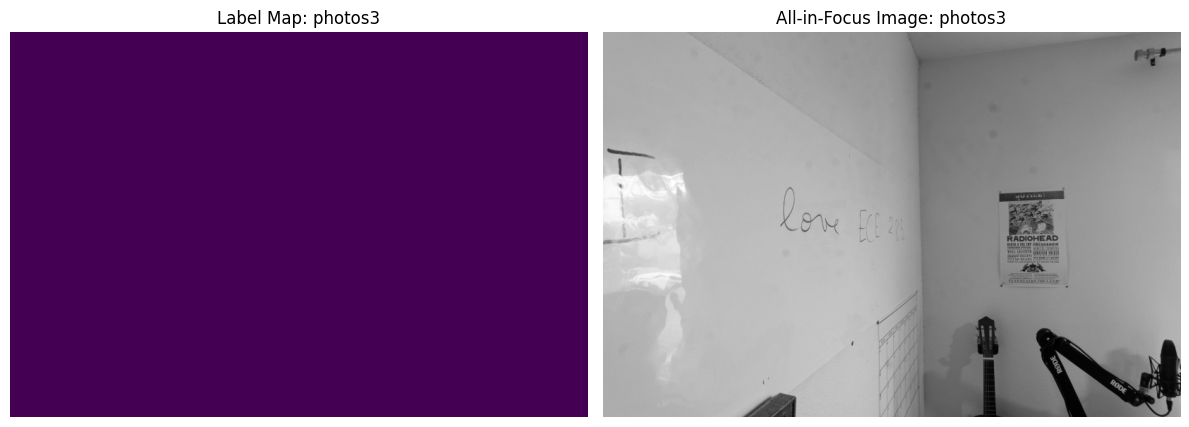

Processing folder: photos4


 20%|██        | 1/5 [01:38<06:34, 98.74s/it]

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy import gradient, exp
from skimage.transform import resize
import maxflow
from tqdm import tqdm
import gc

# ----- Load Focal Stack -----
folder_path = '/Users/yannbaglinbunod/Desktop/ece 285 project/photos4'
image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_filenames.sort()

# ----- Alignment (Recursive Flow Composition) -----
def warp_image(img, flow):
    h, w = img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

def compute_optical_flow_pair(img1, img2):
    dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_MEDIUM)
    dis.setUseSpatialPropagation(True)
    return dis.calc(img1, img2, None)

def estimate_affine(img1, img2):
    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return np.eye(2, 3, dtype=np.float32)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = matcher.match(des1, des2)
    if len(matches) < 4:
        return np.eye(2, 3, dtype=np.float32)
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, _ = cv2.estimateAffinePartial2D(dst_pts, src_pts)
    return M if M is not None else np.eye(2, 3, dtype=np.float32)

def compose_flows(f1, f2):
    h, w, _ = f1.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + f1[..., 0]).astype(np.float32)
    map_y = (grid_y + f1[..., 1]).astype(np.float32)
    f2_warped = np.stack([
        cv2.remap(f2[..., 0], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT),
        cv2.remap(f2[..., 1], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    ], axis=-1)
    return f1 + f2_warped

def invert_flow(flow):
    h, w = flow.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = grid_x + flow[..., 0]
    map_y = grid_y + flow[..., 1]
    flow_inv_x = cv2.remap(-flow[..., 0], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    flow_inv_y = cv2.remap(-flow[..., 1], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return np.stack([flow_inv_x, flow_inv_y], axis=-1)

def align_focal_stack_recursive(stack):
    ref_idx = len(stack) // 2
    h, w = stack[0].shape[:2]
    affine_warped = [cv2.warpAffine(stack[i], estimate_affine(stack[ref_idx], stack[i]), (w, h), flags=cv2.INTER_LINEAR) for i in range(len(stack))]
    flows = [compute_optical_flow_pair(affine_warped[i], affine_warped[i + 1]) for i in range(len(stack) - 1)]
    aligned = []
    for i in range(len(stack)):
        if i == ref_idx:
            aligned.append(stack[i])
            continue
        if i < ref_idx:
            flow = flows[i].copy()
            for j in range(i + 1, ref_idx):
                flow = compose_flows(flow, flows[j])
        else:
            flow = invert_flow(flows[i - 1])
            for j in range(i - 2, ref_idx - 1, -1):
                flow = compose_flows(flow, invert_flow(flows[j]))
        warped = warp_image(stack[i], flow)
        aligned.append(warped)
    return np.stack(aligned)

def compute_common_crop_mask(stack):
    h, w = stack[0].shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)
    for img in stack:
        edges = cv2.Canny(img, 100, 200)
        mask = cv2.bitwise_and(mask, (edges == 0).astype(np.uint8))
    return mask

# ----- Preprocessing -----
def compute_patchwise_gradient_stack(stack, sigma=1.0):
    return np.stack([np.sqrt((gx**2 + gy**2)) for gx, gy in [gradient(gaussian_filter(f, sigma)) for f in stack]])

def compute_data_term(stack, sigma=1.0):
    grad_stack = compute_patchwise_gradient_stack(stack, sigma)
    return np.stack([exp(g) for g in grad_stack])

def downsample_stack(stack, shape):
    return np.stack([resize(f, shape, anti_aliasing=True) for f in stack])

def get_edges(H, W):
    return [(y*W+x, y*W+x+1) for y in range(H) for x in range(W-1)] + \
           [(y*W+x, (y+1)*W+x) for y in range(H-1) for x in range(W)]

def alpha_expansion(data_cost, λ=0.8, max_iters=5):
    N, H, W = data_cost.shape
    flat_cost = data_cost.transpose(1, 2, 0).reshape(-1, N)
    labels = np.argmin(data_cost, axis=0)
    for _ in tqdm(range(max_iters)):
        prev = labels.copy()
        flat_labels = labels.flatten()
        for α in range(N):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(H*W)
            for i in range(H*W):
                g.add_tedge(nodes[i], flat_cost[i, α], flat_cost[i, flat_labels[i]])
            for i, j in get_edges(H, W):
                pi, pj = flat_labels[i], flat_labels[j]
                g.add_edge(nodes[i], nodes[j], λ * abs(α - pj), λ * abs(α - pi))
            g.maxflow()
            for i in range(H*W):
                if g.get_segment(nodes[i]) == 0:
                    flat_labels[i] = α
            labels = flat_labels.reshape(H, W)
            del g
            gc.collect()
        if np.all(labels == prev):
            break
    return labels


# ----- Process multiple folders -----
folder_base = '/Users/yannbaglinbunod/Desktop/ece 285 project'
photo_folders = ['photos1', 'photos2', 'photos3', 'photos4']

for idx, folder in enumerate(photo_folders):
    print(f"Processing folder: {folder}")
    folder_path = os.path.join(folder_base, folder)
    image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_filenames.sort()

    # Load grayscale stack
    focal_stack_gray = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in image_filenames]
    focal_stack_gray = [img for img in focal_stack_gray if img is not None]
    focal_stack_gray = np.stack(focal_stack_gray)

    # Align stack
    focal_stack_gray_aligned = align_focal_stack_recursive(focal_stack_gray)

    # Compute crop mask and crop images
    common_mask = compute_common_crop_mask(focal_stack_gray_aligned)
    x, y, w, h = cv2.boundingRect(common_mask.astype(np.uint8))
    focal_stack_gray_aligned = np.stack([img[y:y+h, x:x+w] for img in focal_stack_gray_aligned])

    # Resize
    target_shape = (int(focal_stack_gray_aligned.shape[1] * 0.4), int(focal_stack_gray_aligned.shape[2] * 0.4))
    focal_stack_small = downsample_stack(focal_stack_gray_aligned, target_shape)

    # Compute data cost and label map
    data_cost = compute_data_term(focal_stack_small)
    label_map = alpha_expansion(data_cost)

    # Reconstruct all-in-focus image
    H, W = label_map.shape
    gray_stack_resized = np.stack([
        resize(img, label_map.shape, preserve_range=True).astype(np.uint8)
        for img in focal_stack_gray_aligned
    ])
    output_gray = np.zeros((H, W), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            output_gray[i, j] = gray_stack_resized[label_map[i, j], i, j]

    # Plot label heatmap side by side with output
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(label_map, cmap='viridis')
    plt.title(f"Label Map: {folder}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_gray, cmap='gray')
    plt.title(f"All-in-Focus Image: {folder}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()